<a href="https://colab.research.google.com/github/gt980103/DLPytorch/blob/master/CIFAR10ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
#使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#设置均值和方差
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
#设置批量大小
batch_size = 32
lr = 0.1
epochs = 150

#设置数据预处理 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  #先四周填充0，在吧图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  #图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

#读取数据集 设置训练集和测试集
train_set = torchvision.datasets.CIFAR10(root='./data',train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

def evl_test_acc(test_loader ,model, device = None):
    if device is None and isinstance(model, torch.nn.Module):
        # 如果没指定device就使用model的device
        device = list(model.parameters())[0].device 
    with torch.no_grad():
        model.eval()
        total = 0.0
        correct = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predict = torch.max(outputs,1)
            total += labels.size(0)
            correct += (labels == predict).sum().item()
        model.train()
    return correct / total

import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import time

#model = torchvision.models.resnet50(pretrained=True)
#in_features = model.fc.in_features
#model.fc = nn.Linear(in_features, 10)
model = torchvision.models.resnet18(num_classes = 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
#optimizer = optim.Adam(model.parameters(), lr=lr)

start_time = time.time()
each_epoch_time = time.time()

test_accs = []
train_accs = []

for epoch in range(epochs):
    running_loss = 0.0
    train_total = 0.0
    train_correct = 0.0
    start = time.time()

    if epoch % 10 == 9:
      lr = lr / 2
      optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
      #optimizer = optim.Adam(model.parameters(), lr=lr)
    for i,data in enumerate(train_loader,0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        #清空梯度
        optimizer.zero_grad()
        #正向传播 反向传播 更新参数
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        #记录损失
        #running_loss += loss.item()
        
        #训练集数量 训练集正确数量
        train_total += labels.size(0)
        _, predict = torch.max(output.data,1)
        train_correct += (labels == predict).sum().item()      
        #每50组batch 打印一次
        # if i % 50 == 49:
        #     print('[%d, %5d] loss: %.5f train_acc: %.5f time: %.3f sec' % (epoch + 1, i + 1, running_loss / 50, train_correct / train_total ,time.time()-each_epoch_time))
        #     running_loss = 0.0
        #     each_epoch_time = time.time()
    #记录一次epoch的训练误差 测试误差 训练时间
    test_acc = evl_test_acc(test_loader, model)
    test_accs.append(test_acc)
    train_accs.append(train_correct / train_total)
    print('epoch %d, train acc: %.5f, test acc: %.5f, time: %.3f sec'
              % (epoch + 1,  train_correct / train_total, test_acc, time.time() - start))
    print("total time %.3f sec" % (time.time() - start_time))

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
epoch 1, train acc: 0.27590, test acc: 0.39240, time: 42.687 sec
total time 42.688 sec
epoch 2, train acc: 0.40990, test acc: 0.46520, time: 42.305 sec
total time 84.993 sec
epoch 3, train acc: 0.48196, test acc: 0.51530, time: 42.747 sec
total time 127.742 sec
epoch 4, train acc: 0.51616, test acc: 0.52480, time: 43.601 sec
total time 171.344 sec
epoch 5, train acc: 0.54670, test acc: 0.55590, time: 43.335 sec
total time 214.679 sec
epoch 6, train acc: 0.55986, test acc: 0.54060, time: 42.769 sec
total time 257.449 sec
epoch 7, train acc: 0.56960, test acc: 0.55610, time: 41.711 sec
total time 299.161 sec
epoch 8, train acc: 0.58014, test acc: 0.57980, time: 41.584 sec
total time 340.746 sec
epoch 9, train acc: 0.58126, test acc: 0.58620, time: 41.978 sec
total time 382.725 sec
epoch 10, train acc: 0.65878, test acc: 0.66880, time: 41.263 sec
total time 423.988 sec
epoch 11, train acc: 0.66106, te

In [0]:
PATH = './cifar_resnet18.pth'
torch.save(model.state_dict(), PATH)

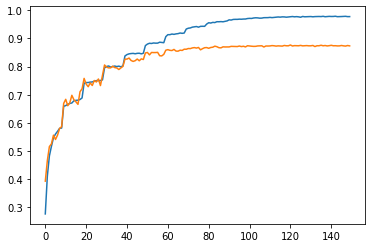

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
x = range(len(train_accs))
plt.plot(x,train_accs)
plt.plot(x,test_accs)
plt.show()